In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
ping_df = pd.read_json("grammarly_data_exercise.json", orient='records', convert_dates=False)

In [4]:
ping_df.head()

,date,timestamp,uid,isFirst,utmSource
0,2016-02-29,1456732801255,g4Hjpoji4dmv,False,Biznesowe+Rewolucje
1,2016-02-29,1456732801556,g4Hjpoji4dmv,False,Biznesowe+Rewolucje
2,2016-02-29,1456732801770,75121338,False,program
3,2016-02-29,1456732803129,11l0tD2wFPFO,False,None
4,2016-02-29,1456732803610,56429432,False,None


# 1. Looking at daily active users over the month

In [5]:
tot_users = len(ping_df.uid.unique()) 
n_new_users = len(ping_df[ping_df.isFirst == True].uid.unique())

In [6]:
def f(x):
    try:
        return int(x)
    except:
        return None    

In [7]:
ping_df['registered'] = ping_df.uid.apply(f)
n_reg_users = len(ping_df[ping_df.registered.notna()].registered.unique())

In [8]:
print("Total pings: " + str(len(ping_df)))
print("Total users active in Feb: " + str(tot_users))
print("Total new users: " + str(n_new_users))
print("Total registered users active in Feb: " + str(n_reg_users))

Total pings: 4823567
Total users active in Feb: 246840
Total new users: 86598
Total registered users active in Feb: 180009


In [9]:
# Check if some users are listed as first time users on different days
first_count = ping_df.groupby(ping_df.uid).isFirst.sum().sort_values()
four_uid = first_count[first_count > 3].index.values
four_uid
for uid_val in four_uid:
    ndays = len(ping_df[(ping_df.uid == uid_val) & (ping_df.isFirst == True)].groupby(ping_df.date))
    if ndays > 1:
        print("Multiple days")

In [16]:
# Users grouped by date
daily_users = ping_df['uid'].groupby(ping_df['date']).unique().apply(len)
daily_users.index.values[0]
short_dates = [s[6:] for s in daily_users.index.values]

In [18]:
# First time users grouped by date
grouped = ping_df[ping_df['isFirst']].groupby(ping_df['date']).uid
new_daily_users = grouped.unique().apply(len)
new_short_dates = [s[6:] for s in new_daily_users.index.values]

In [21]:
# Users that were active prior to February
new_users = ping_df[ping_df.isFirst].uid.unique()
prevmonth_users = ping_df[~ping_df.uid.isin(new_users)].uid.groupby(ping_df.date).unique().apply(len)
assert(daily_users[0] == prevmonth_users[0]+new_daily_users[0]) # sanity check

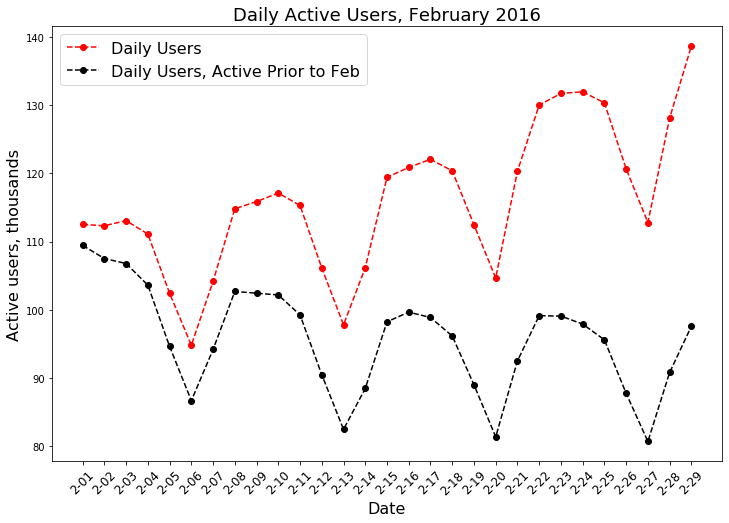

In [20]:
plt.figure(figsize=(12,8))
plt.plot(short_dates, daily_users.values/1000, 'ro--', label='Daily Users')
plt.plot(short_dates, prevmonth_users/1000, 'ko--', label='Daily Users, Active Prior to Feb')
plt.xticks(rotation=45, fontsize=12);
plt.xlabel("Date", fontsize=16)
plt.ylabel("Active users, thousands", fontsize=16)
#plt.ylim(0, 150)
plt.title("Daily Active Users, February 2016", fontsize=18)
plt.legend(loc='best', fontsize=16)

In [22]:
daily_users[0:7].mean(), daily_users[7:14].mean(), daily_users[14:21].mean(), daily_users[21:28].mean()

(107197.57142857143,
 110448.85714285714,
 117161.85714285714,
 126506.85714285714)

In [23]:
(daily_users[21:28].mean() - daily_users[0:7].mean())/daily_users[0:7].mean()

0.180128014627197

Text(0.5, 1.0, 'New User Fraction of Daily Users, February 2016')

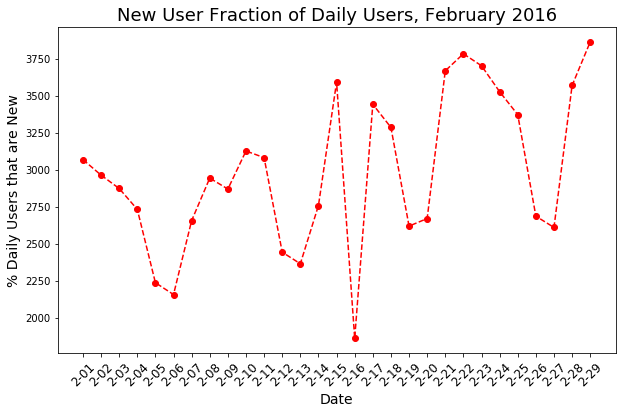

In [24]:
plt.figure(figsize=(10,6))
plt.plot(new_short_dates, new_daily_users.values, 'ro--')
plt.xticks(rotation=45, fontsize=12);
plt.xlabel("Date", fontsize=14)
plt.ylabel("% Daily Users that are New", fontsize=14)
#plt.yticks(ticks=[i*0.01 for i in range(0, 11)], fontsize=12)
#plt.ylim(0,4000)
#plt.ylim(0, 0.1)
plt.title("New User Fraction of Daily Users, February 2016", fontsize=18)

In [25]:
npings_per_user = ping_df.groupby(ping_df.uid).timestamp.unique().apply(len)

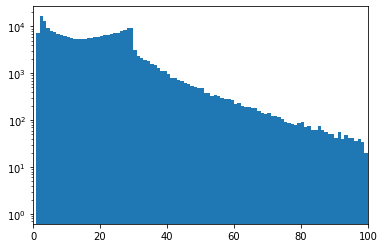

In [26]:
plt.figure()
plt.hist(npings_per_user, bins=2807)
plt.yscale('log')
plt.xlim(0, 100);
# The first peak are users that check in a few times and then never use the app again, the second peak is most likely from users that check in once a day

# 2. Retention Rates of Different Cohorts

In [27]:
cohort_dates = ['2016-02-04', '2016-02-10', '2016-02-14']

In [28]:
x_days = []
y_pct = []
n_users = []
# For each cohort
for day in cohort_dates:
    users_list = ping_df[(ping_df['date'] == day) & (ping_df.isFirst == True)].uid.unique()
    n_cohort = len(users_list)
    cohort = ping_df[ping_df['uid'].isin(users_list)]
    n_users.append(n_cohort)
    retention = cohort.groupby(cohort['date']).uid.unique().apply(len).values
    ret_dates = np.unique(cohort.date.apply(lambda x: x[6:]).values)
    retention_pct = retention/n_cohort
    x_days.append(ret_dates)
    y_pct.append(retention_pct)

(0, 1.1)

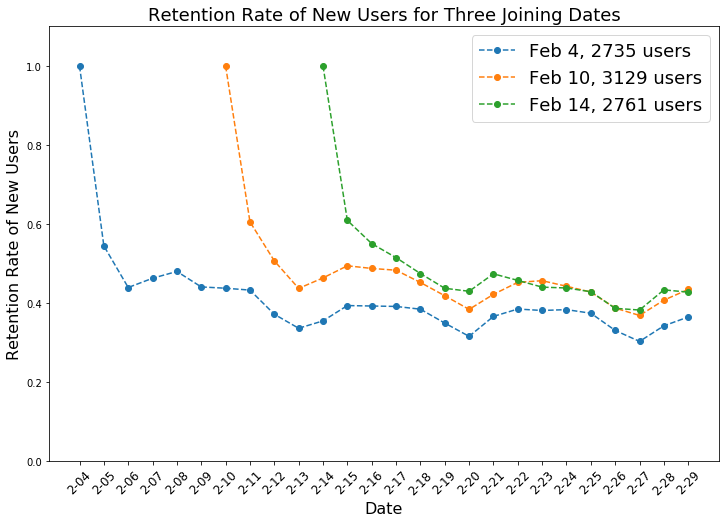

In [29]:
plt.figure(figsize=(12,8))
labels = [('Feb 4, %d users' % n_users[0]), ('Feb 10, %d users' % n_users[1]), ('Feb 14, %d users' % n_users[2])]
for x, y, label in zip(x_days, y_pct, labels):
    plt.plot(x, y, linestyle='--', marker='o', label=label)
plt.xticks(rotation=45, fontsize=12);
plt.xlabel("Date", fontsize=16)
plt.ylabel("Retention Rate of New Users", fontsize=16)
plt.title("Retention Rate of New Users for Three Joining Dates", fontsize=18)
plt.legend(fontsize=18)
plt.ylim(0,1.1)

In [30]:
nth_day = [i for i in range(26)]
x_days_normalized = np.array([nth_day, nth_day[0:20], nth_day[0:16]])

(0, 1.1)

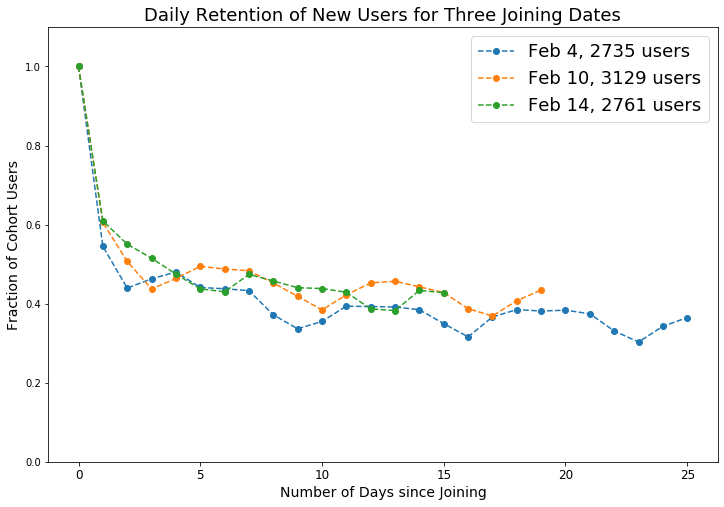

In [31]:
plt.figure(figsize=(12,8))
labels = [('Feb 4, %d users' % n_users[0]), ('Feb 10, %d users' % n_users[1]), ('Feb 14, %d users' % n_users[2])]
for x, y, label in zip(x_days_normalized, y_pct, labels):
    plt.plot(x, y, linestyle='--', marker='o', label=label)
plt.xticks(fontsize=12);
plt.xlabel("Number of Days since Joining", fontsize=14)
plt.ylabel("Fraction of Cohort Users", fontsize=14)
plt.title("Daily Retention of New Users for Three Joining Dates", fontsize=18)
plt.legend(fontsize=18)
plt.ylim(0,1.1)

# Exploring source

In [32]:
source_counts = ping_df.utmSource.value_counts()

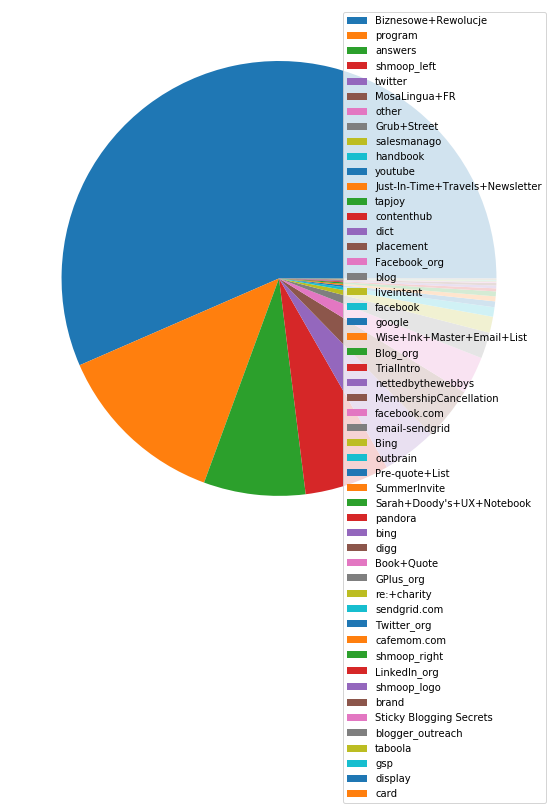

In [33]:
plt.figure(figsize=(10,10))
plt.pie(source_counts);
plt.legend(labels=source_counts.index.values, loc='upper right')

In [ ]:
first_source_counts = ping_df[ping_df.isFirst].utmSource.value_counts()

Text(0, 0.5, 'Number of first time pings')

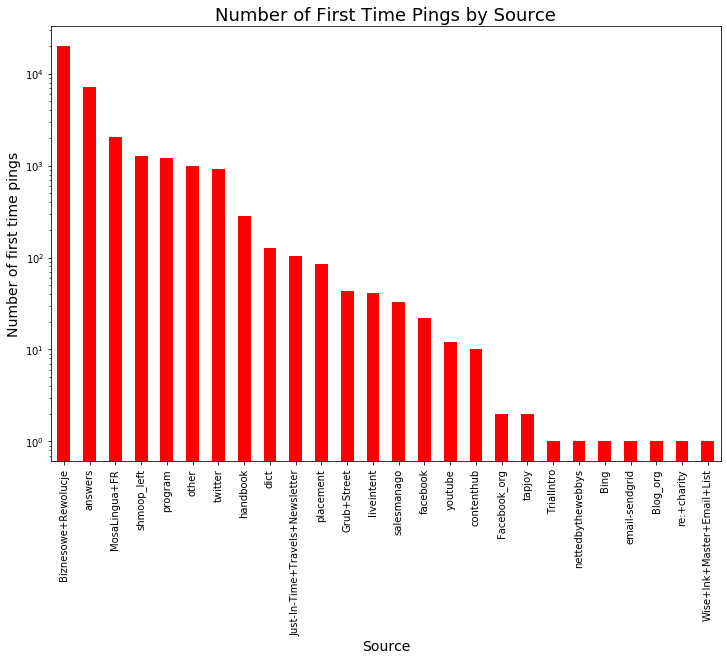

In [69]:
plt.figure(figsize=(12,8))
# source_counts.plot(kind='bar')
first_source_counts.plot(kind='bar', color='red')
plt.yscale('log')
plt.title("Number of First Time Pings by Source", fontsize=18)
plt.xlabel("Source", fontsize=14)
plt.ylabel("Number of first time pings", fontsize=14)

In [36]:
first_source_counts

Biznesowe+Rewolucje                19962
answers                             7074
MosaLingua+FR                       2071
shmoop_left                         1267
program                             1219
other                                992
twitter                              927
handbook                             283
dict                                 127
Just-In-Time+Travels+Newsletter      104
placement                             85
Grub+Street                           43
liveintent                            41
salesmanago                           33
facebook                              22
youtube                               12
contenthub                            10
Facebook_org                           2
tapjoy                                 2
TrialIntro                             1
nettedbythewebbys                      1
Bing                                   1
email-sendgrid                         1
Blog_org                               1
re:+charity     

In [42]:
top_sources = first_source_counts.index.values[0:10]
top_sources

array(['Biznesowe+Rewolucje', 'answers', 'MosaLingua+FR', 'shmoop_left',
       'program', 'other', 'twitter', 'handbook', 'dict',
       'Just-In-Time+Travels+Newsletter'], dtype=object)

In [43]:
x_sources_prev = []
y_pct_sources_prev = []
n_prev_users_source = []
prev_month_users = ping_df[~ping_df.uid.isin(new_users)]
for source in top_sources:
    prev_uid = prev_month_users[prev_month_users['utmSource'] == source].uid.values
    n_prev_users = len(np.unique(prev_uid)) 
    n_prev_users_source.append(n_prev_users)
    cohort = ping_df[ping_df['uid'].isin(prev_uid)]
    retention = cohort['uid'].groupby(cohort['date']).unique().apply(len).values
    ret_dates = cohort['uid'].groupby(cohort['date']).unique().apply(len).index.values
    retention_pct = retention/n_prev_users
    x_sources_prev.append(ret_dates)
    y_pct_sources_prev.append(retention_pct)

In [44]:
top_sources, n_prev_users_source

(array(['Biznesowe+Rewolucje', 'answers', 'MosaLingua+FR', 'shmoop_left',
        'program', 'other', 'twitter', 'handbook', 'dict',
        'Just-In-Time+Travels+Newsletter'], dtype=object),
 [65457, 7867, 4182, 5633, 14232, 3343, 4219, 811, 203, 408])

In [71]:
labels = [top_sources[i] + ", " + str(n_prev_users_source[i]) for i in range(10)]

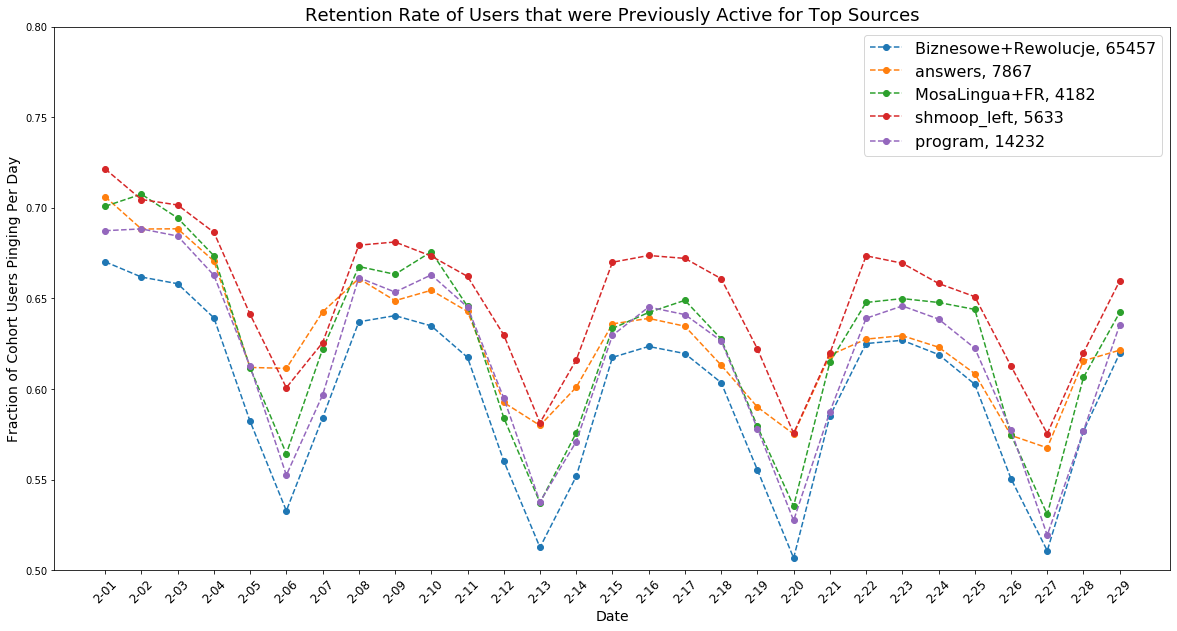

In [72]:
plt.figure(figsize=(20,10))
for y, label in zip(y_pct_sources_prev[0:5], labels[0:5]):
    plt.plot(short_dates, y, linestyle='--', marker='o', label=label)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Fraction of Cohort Users Pinging Per Day", fontsize=14)
plt.title("Retention Rate of Users that were Previously Active for Top Sources", fontsize=18)
plt.legend(fontsize=16)
plt.ylim(0.5,0.8)
plt.xticks(rotation=45, fontsize=12);

In [50]:
x_sources = []
y_pct_sources = []
n_new_users_source = []
first_day_users = ping_df[(ping_df['date'] == '2016-02-10') & (ping_df['isFirst'] == True)]
for source in top_sources[0:5]:
    new_uid = first_day_users[first_day_users['utmSource'] == source].uid.values
    n_new_users = len(np.unique(new_uid)) #change this var name, already used
    n_new_users_source.append(n_new_users)
    cohort = ping_df[ping_df['uid'].isin(new_uid)]
    retention = cohort['uid'].groupby(cohort['date']).unique().apply(len).values
    ret_dates = cohort['uid'].groupby(cohort['date']).unique().apply(len).index.values
    retention_pct = retention/n_new_users
    x_sources.append(ret_dates)
    y_pct_sources.append(retention_pct)

(0, 1.1)

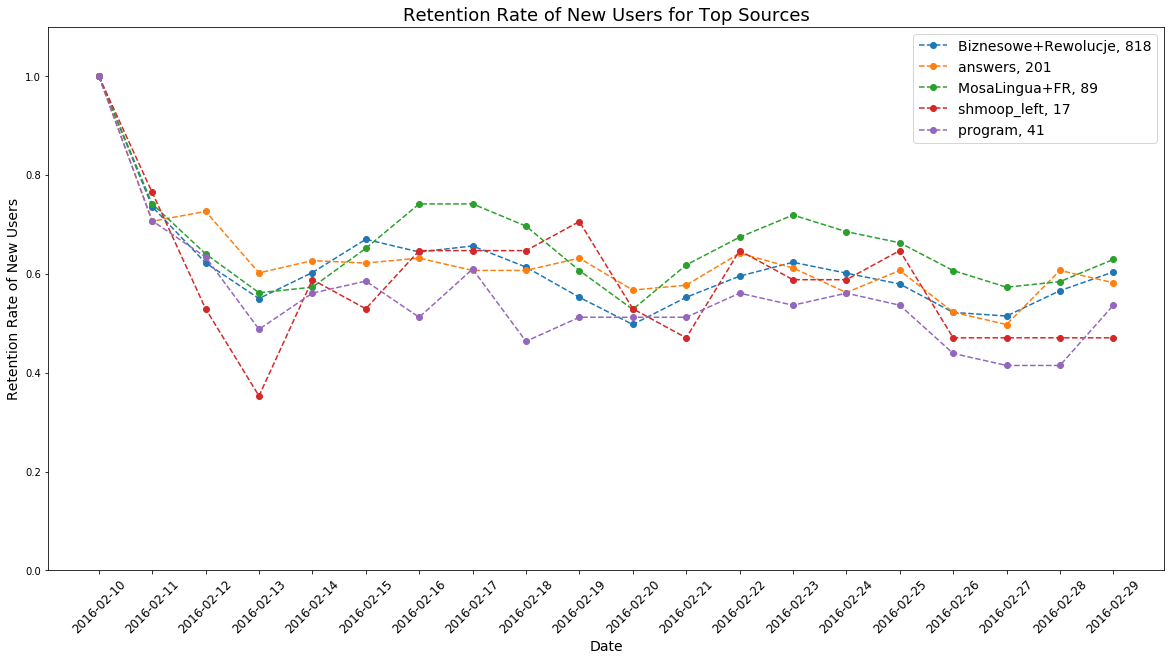

In [66]:
plt.figure(figsize=(20,10))
labels = [top_sources[i] + ", " + str(n_new_users_source[i]) for i in range(5)]
for x, y, label in zip(x_sources, y_pct_sources, labels):
    plt.plot(x, y, linestyle='--', marker='o', label=label)
plt.xticks(rotation=45, fontsize=12);
plt.xlabel("Date", fontsize=14)
plt.ylabel("Retention Rate of New Users", fontsize=14)
plt.title("Retention Rate of New Users for Top Sources", fontsize=18)
plt.legend(fontsize=14)
plt.ylim(0,1.1)

In [63]:
new_users = ping_df[ping_df.isFirst].uid.unique()
prevmonth_sources = ping_df[~ping_df.uid.isin(new_users)].groupby(ping_df.utmSource).uid.unique().apply(len).sort_values(ascending=False)

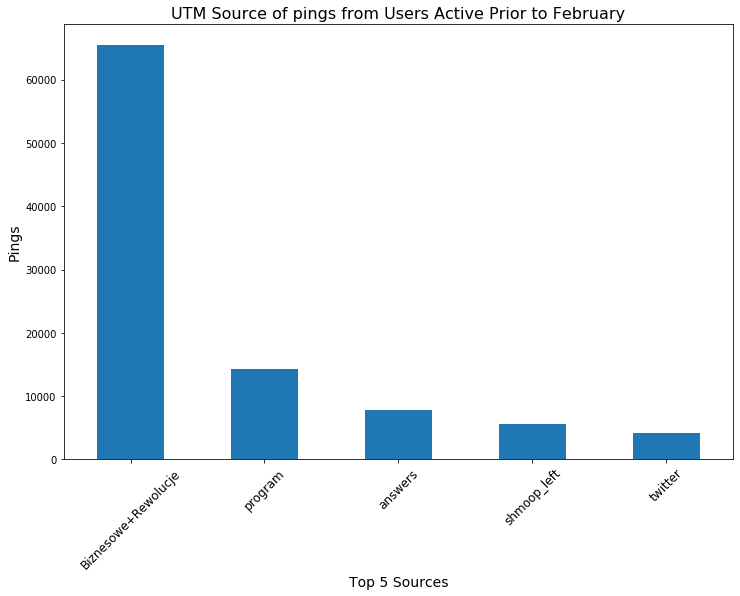

In [68]:
plt.figure(figsize=(12,8))
prevmonth_sources[0:5].plot(kind='bar')
plt.xlabel("Top 5 Sources", fontsize=14)
plt.xticks(rotation=45, fontsize=12);
plt.ylabel("Pings", fontsize=14)
plt.title("UTM Source of pings from Users Active Prior to February", fontsize=16);

In [77]:
sorted_dates = list(ping_df.date.unique())

In [78]:
sorted_dates.sort(key=lambda s: list(map(int, s.split('-'))))

In [82]:
# For each cohort
n_cohort_sources = []
y_pct_sources = []
for day in sorted_dates:
    users_list = ping_df[(ping_df['date'] == day) & (ping_df.isFirst == True)].uid.unique()
    n_cohort = len(users_list)
    n_cohort_sources.append(n_cohort)
    cohort = ping_df[ping_df['uid'].isin(users_list)]
    retained_users = cohort.groupby(cohort['date']).uid.unique().apply(len).values
    retention_padded = np.zeros((1,29))
    retention_padded[0, 0:len(retained_users)] = retained_users
    y_pct_sources.append(np.copy(retention_padded))
reversed_list = n_cohort_sources[::-1]
reversed_cohort_sum = [sum(reversed_list[0:x:1]) for x in range(0, 30)]
n_denom = [sum(n_cohort_sources)-reversed_cohort_sum[i] for i in range(29)]
ret_sum = sum(y_pct_sources)
retention_over_all_cohorts = ret_sum/n_denom

Text(0.5, 1.0, 'Retention of Users that pinged in February')

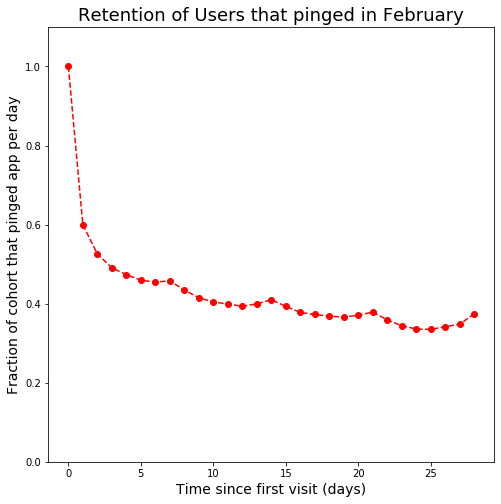

In [89]:
nth_day = [i for i in range(29)]
plt.figure(figsize=(8,8))
plt.plot(nth_day, retention_over_all_cohorts[0], 'ro--')
plt.ylim(0, 1.1)
plt.xlabel("Time since first visit (days)", fontsize=14)
plt.ylabel("Fraction of cohort that pinged app per day", fontsize=14)
plt.title("Retention of Users that pinged in February", fontsize=18)


Let's study the Feb 3rd cohort

In [34]:
uid_day3 = ping_df[(ping_df['date'] == '2016-02-03') & (ping_df.isFirst == True)].uid.values
n_day3_users = len(uid_day3)
day3_cohort = ping_df[ping_df['uid'].isin(uid_day3)]
retention = day3_cohort['uid'].groupby(day3_cohort['date']).unique().apply(len).values
ret_dates = day3_cohort['uid'].groupby(day3_cohort['date']).unique().apply(len).index.values
retention_pct = retention/n_day3_users

(0, 1.1)

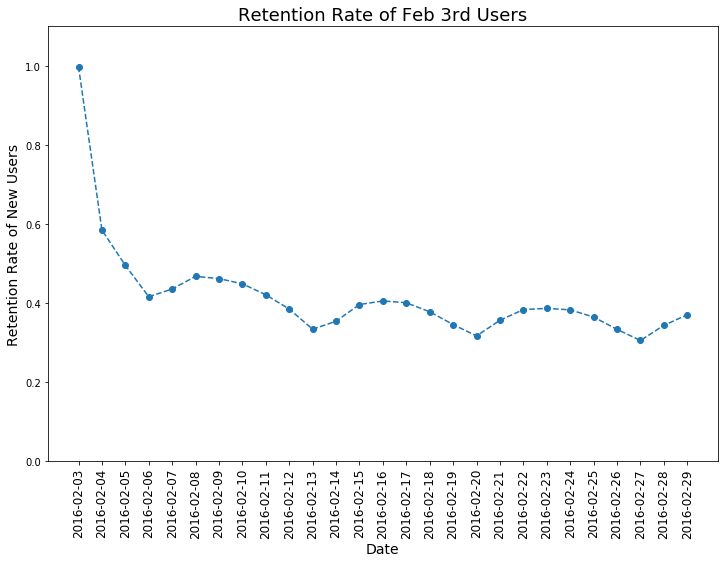

In [35]:
plt.figure(figsize=(12,8))
plt.plot(ret_dates, retention_pct, linestyle='--', marker='o')
plt.xticks(rotation=90, fontsize=12);
plt.xlabel("Date", fontsize=14)
plt.ylabel("Retention Rate of New Users", fontsize=14)
plt.title("Retention Rate of Feb 3rd Users", fontsize=18)
plt.ylim(0,1.1)

In [36]:
start_uids = day3_cohort[(day3_cohort.date == '2016-02-03') | (day3_cohort.date == '2016-02-04') | (day3_cohort.date == '2016-02-05')].uid.unique()

In [37]:
rest_uids = day3_cohort[(day3_cohort.date != '2016-02-03') & (day3_cohort.date != '2016-02-04') & (day3_cohort.date != '2016-02-05')].uid.unique()

In [38]:
quit_uids = [i for i in start_uids if i not in rest_uids]

In [39]:
retained_uids = day3_cohort[(day3_cohort.date == '2016-02-24') | (day3_cohort.date == '2016-02-25') | (day3_cohort.date == '2016-02-26') | (day3_cohort.date == '2016-02-27') | (day3_cohort.date == '2016-02-28') | (day3_cohort.date == '2016-02-29')].uid.unique()

In [40]:
day3_cohort[day3_cohort.uid.isin(quit_uids)].utmSource

2990143    Biznesowe+Rewolucje
2990194    Biznesowe+Rewolucje
2990441                   None
2990442                   None
2990443                   None
                  ...         
4382407                   None
4385071                   None
4390903                   None
4391727                   None
4395490                   None
Name: utmSource, Length: 4585, dtype: object

In [41]:
all_uids = ping_df.uid.unique()

In [69]:
# Only one first time user in the day3 cohort is associated with two sources rather than one
np.unique(day3_cohort[day3_cohort.isFirst].groupby(day3_cohort.uid).utmSource.unique().apply(len).values)
myseries = day3_cohort[day3_cohort.isFirst].groupby(day3_cohort.uid).utmSource.unique().apply(len)
myseries[myseries == 2]

uid
79551646    2
Name: utmSource, dtype: int64

In [79]:
quit_sources = day3_cohort[(day3_cohort.uid.isin(quit_uids)) & (day3_cohort.isFirst == True)].utmSource.value_counts()

In [80]:
retained_sources = day3_cohort[(day3_cohort.uid.isin(retained_uids)) & (day3_cohort.isFirst == True)].utmSource.value_counts()

In [83]:
total_sources = day3_cohort[day3_cohort.isFirst == True].utmSource.value_counts()

In [88]:
quit_pct = quit_sources/total_sources
ret_pct = retained_sources/total_sources

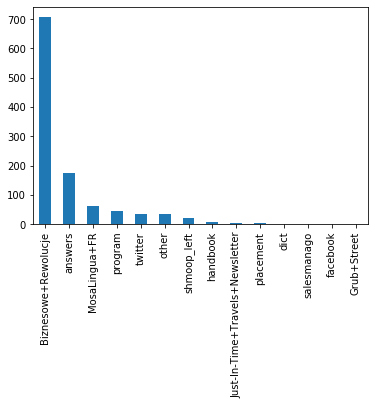

In [91]:
plt.figure()
total_sources.plot(kind='bar')

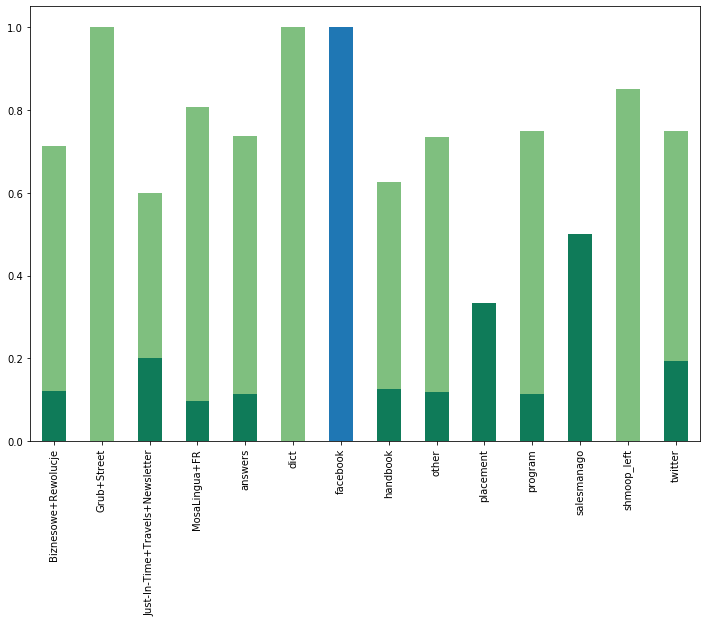

In [90]:
plt.figure(figsize=(12,8))
quit_pct.plot(kind='bar')
ret_pct.plot(kind='bar', color='g', alpha=0.5)